In [1]:
import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
import random
from IPython.display import HTML
from matplotlib import animation
import timeit

Functions involving dynamics of lattice

In [2]:
def energy(sigma, J, H):
    ''' Calculate lattice Energy from Hamiltonian
        E = -J * sum(S(i)*S(j);i^j) - H * sum(S(j);j)
     Parameters
     ----------
     sigma : Full lattice that includes boundaries
     H : External field
     J : Interaction 
    '''
    return (-J * np.sum(sigma[:-1,:] * sigma[1:,:]) + -J * np.sum(sigma[:,:-1] * sigma[:,1:]) + -H * np.sum(sigma))

In [3]:
def setBoundary(sigma):
    sigma[0,:]  = sigma[-1,:]
    sigma[-1,:] = sigma[-2,:]
    sigma[:,0]  = sigma[1,:]
    sigma[:,-1] = sigma[2,:]
    return

In [4]:
def mcflip_sublat(sigma,a,b, J, H):
    """Update on sublattices defined by and randomly flip with probability
    set by the relative Gibbs weight."""
    
    # localH acts on the bulk sublattice which is defined by the slice
    # sigma[1+a:-1:2, 1+b:-1:2]
    Lx, Ly = sigma.shape
    localH = H* sigma[1+a:-1:2, 1+b:-1:2] + J * sigma[1+a:-1:2, 1+b:-1:2]*(
            sigma[2+a:   :2, 1+b: -1:2] + # to the right
            sigma[  a: -2:2, 1+b: -1:2] + # to the left
            sigma[1+a: -1:2, 2+b:   :2] + # up
            sigma[1+a: -1:2,   b: -2:2]   # down 
            )
    
    #metropolis probability:
    p = np.exp(-2 * localH)
    sigma[1+a:-1:2, 1+b:-1:2] *= -1 * (2*(np.random.rand(Lx//2-1,Ly//2-1) < p) - 1)          
    return

In [5]:
#flips the spins and sets the periodic boundaries
def mcflip(sigma, J, H):
    setBoundary(sigma)
    mcflip_sublat(sigma,0,0, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,1,0, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,0,1, J, H)
    setBoundary(sigma)  
    mcflip_sublat(sigma,1,1, J, H)
    setBoundary(sigma)  
    return

Correlation Functions

In [6]:
def acf(x, length=20):
    ''' Auto Correlation Function'''
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
    for i in range(1, length)])

In [7]:
def tp_corr(sigma,n,length=50):#two point correlation function 
    L=len(sigma)
    C=[]
    for i in range(1,length):
        Xi=[]
        Xj=[]
        for j in range(n):
            x=np.random.randint(0,L)
            y=np.random.randint(0,L)
            Xi+=[sigma[x][y]]
            Xj+=[sigma[x][(y+i)%L]]
        Xi=np.array(Xi)
        Xj=np.array(Xj)
        C+=[(np.mean(Xi*Xj)-np.mean(Xi)*np.mean(Xj))/np.var(Xi)]     
    return C

In [8]:
def corr_len(auto_corr):
    for i, ac in enumerate(auto_corr):
        if (np.abs(ac - (1/np.e)) <= 0.005) and (np.abs(ac - (1/np.e)) < np.abs(auto_corr[(i+1)%len(auto_corr)] - (1/np.e))):
            return i

Sampling functions

In [18]:
def magnetization(sigma):
    return np.mean(sigma[1:-1,1:-1]) # exclude boundary spins

In [19]:
def runSample(nSteps = 10000, subSample = 10):
    """Run nSteps Monte Carlo sweeps on the 2D Ising model.
       Does not initialize the sample so can be called sequentially without
       reinitialization if desired.
   
       Returns:
           histMag -- array of magnetizations at every subSample timesteps
           histEn  -- array of energies at every subSample timesteps
   """
   
   # create lists to grow
    histMag = []
    histEn = []
        
    for t in range(nSteps):
        mcflip(sigma, J, H)
                 
        if t % subSample == 0:
            histMag.append(magnetization(sigma))
            histEn.append(energy(sigma, J, H))
    # return as arrays
    return (np.array(histMag), np.array(histEn))

In [20]:
def run_sample_ksi(nSteps,subSample):
    """this function takes samples to calculate the positional correlation length 
       using the functions tp_corr
    """
    histksi = []
    for t in range(nSteps):
        mcflip(sigma, J, H)    
        if t % subSample == 0:
            ksi=corr_len(tp_corr(sigma,50,length=20))
            if ksi is not None: 
                histksi.append(ksi)
            else:
                histksi.append(0)
    # return as arrays
    return np.array(histksi)

In [21]:
def Generate(sigma,J,H):
    '''
    this function is the automatic data creator from our simulation
    it takes 6000 samples at first, dumps the first 2000 and then goes on with the method 
    explained in the report to sample efficiently and with good quality
    '''
    Mag0, En0= runSample(6000,1) 
    ac = acf(Mag0[2000:],length=900)
    step = corr_len(ac)
    Mag, En = Mag0[2000::step], En0[2000::step]
    if step is None:                              #when step is less than 1 we set step=1
        step=1              
    if 1000//step < 100:                          #when step is big we get more data 
        Mag0, En0=runSample((500*step-1000),step)
        Mag = np.append(Mag,Mag0)
        En = np.append(En,En0)
     
   
    return(Mag, En, step)

Simulation

In [22]:
Jcrit = np.log(1+np.sqrt(2.))/2 # J in Critical temperatur

In [23]:
Jcrit

0.44068679350977147

In [24]:
lx=100
ly=100
J=Jcrit*1.5 # T < Tc
H=0
M=[]
sigma=np.random.choice([1,-1],size=(lx,ly))
for i in range (6000) :
    mcflip(sigma,J,H)
    M.append(magnetization(sigma))

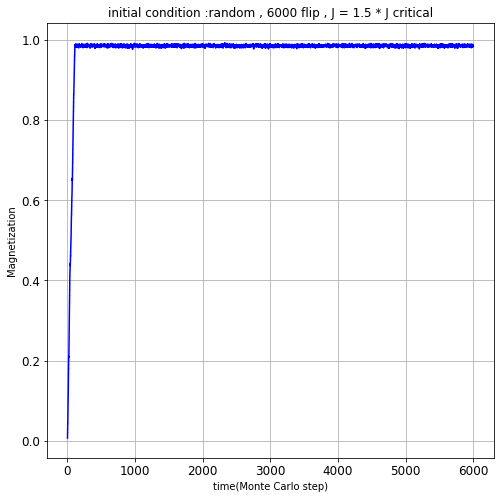

In [25]:
fig = plt.figure(figsize=(8,8))
plt.plot(M,'.b-',markersize=0.1)
plt.title("initial condition :random , 6000 flip , J =0.66")
plt.xlabel('time(Monte Carlo step)')
plt.ylabel('Magnetization')
plt.tick_params(labelsize=12)
plt.grid()

In [53]:
start=timeit.default_timer()
listt1=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist1=[]
Elist1=[]
Xilist1=[]
Cvlist1=[]
lx, ly = 100, 100
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt1:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist1+=[np.mean(M)]
    Elist1+=[np.mean(E)]
    Xilist1+=[np.var(M)]
    Cvlist1+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start) 

creation time : 674.5298430000003


In [55]:
start=timeit.default_timer()
listt2=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist2=[]
Elist2=[]
Xilist2=[]
Cvlist2=[]
lx, ly = 120, 120
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt2:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist2+=[np.mean(M)]
    Elist2+=[np.mean(E)]
    Xilist2+=[np.var(M)]
    Cvlist2+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)

creation time : 993.4187053999995


In [56]:
start=timeit.default_timer()
listt3=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist3=[]
Elist3=[]
Xilist3=[]
Cvlist3=[]
lx, ly = 160, 160
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt3:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist3+=[np.mean(M)]
    Elist3+=[np.mean(E)]
    Xilist3+=[np.var(M)]
    Cvlist3+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start) 

creation time : 1482.4034544999995


In [57]:
start=timeit.default_timer()
listt4=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist4=[]
Elist4=[]
Xilist4=[]
Cvlist4=[]
lx, ly = 220, 220
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt4:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist4+=[np.mean(M)]
    Elist4+=[np.mean(E)]
    Xilist4+=[np.var(M)]
    Cvlist4+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)  

creation time : 2646.554360599999


In [58]:
start=timeit.default_timer()
listt5=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist5=[]
Elist5=[]
Xilist5=[]
Cvlist5=[]
lx, ly = 300, 300
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt5:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist5+=[np.mean(M)]
    Elist5+=[np.mean(E)]
    Xilist5+=[np.var(M)]
    Cvlist5+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)  

creation time : 3759.1838422


In [219]:
start=timeit.default_timer()
listt6=[0.438,0.439,0.440,0.4405,0.4408,0.441,0.4415,0.442,0.443,0.444,0.445,0.448,0.45]
Mlist6=[]
Elist6=[]
Xilist6=[]
Cvlist6=[]
lx, ly = 400, 400
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
for a in listt6:
    J = a #Interaction
    H = 0 #External field
    # make the initial 'full lattice'
    
    M, E,Step = Generate(sigma,J,H)
    Mlist6+=[np.mean(M)]
    Elist6+=[np.mean(E)]
    Xilist6+=[np.var(M)]
    Cvlist6+=[np.var(E)]
stop=timeit.default_timer()
print('creation time :',stop-start)  

creation time : 9365.692084899987


nu:

In [267]:
JclistO= [listt1[np.argmax(Cvlist1)],listt2[np.argmax(Cvlist2)],listt3[np.argmax(Cvlist3)],listt4[np.argmax(Cvlist4)],listt5[np.argmax(Cvlist5)]]
Jclist= [listt1[np.argmax(Cvlist1)],listt3[np.argmax(Cvlist3)],listt5[np.argmax(Cvlist5)]]
L_list=[100,160,300]
L_listO=[100,120,160,220,300]
Jc_list = [np.abs(x - Jcrit) for x in Jclist]
T_list = [np.abs(x**-1 - Jcrit**-1) for x in Jclist]
T_listO = [np.abs(x**-1 - Jcrit**-1) for x in JclistO]

In [268]:
fit=np.polyfit(np.log(L_list),np.log(T_list),1)

nu is 1.0481259726888392


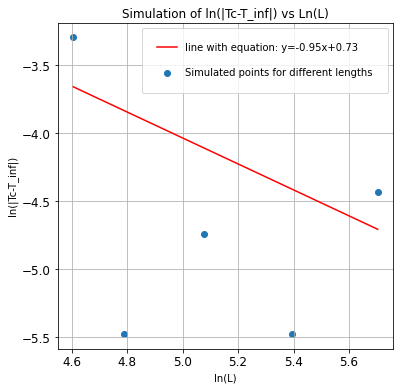

In [269]:
fig = plt.figure(figsize=(6,6))
plt.xlabel("ln(L)")
plt.ylabel("ln(|Tc-T_inf|)")
plt.title("Simulation of ln(|Tc-T_inf|) vs Ln(L)")
plt.scatter(np.log(L_listO),np.log(T_listO),label='Simulated points for different lengths')
plt.plot(np.log(L_list),np.log(L_list)*fit[0]+fit[1],color='r',label='line with equation: y='+str(round(fit[0], 2))+'x+'+str(round(fit[1],2)))
plt.tick_params(labelsize=12)
plt.legend(borderpad=1.5, labelspacing=1.5)
plt.grid()
nu = -(1/fit[0])
print('nu is',nu)

Beta:

In [270]:
Mclist= [Mlist1[np.argmax(Cvlist1)],Mlist2[np.argmax(Cvlist2)],Mlist3[np.argmax(Cvlist3)],Mlist5[np.argmax(Cvlist5)]]
Mclist=np.abs(Mclist)
Lo_list=[100,120,160,300]
MclistO= [Mlist1[np.argmax(Cvlist1)],Mlist2[np.argmax(Cvlist2)],Mlist3[np.argmax(Cvlist3)],Mlist4[np.argmax(Cvlist4)],Mlist5[np.argmax(Cvlist5)]]
MclistO=np.abs(MclistO)

In [272]:
fit=np.polyfit(np.log(Lo_list),np.log(Mclist),1)

beta is 0.11566089671682021


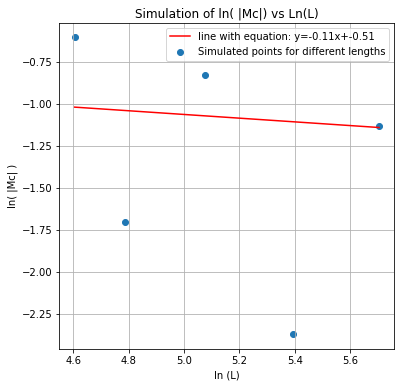

In [273]:
fig = plt.figure(figsize=(6,6))
plt.xlabel("ln (L)")
plt.ylabel("ln( |Mc| )")
plt.title("Simulation of ln( |Mc|) vs Ln(L)")
plt.scatter(np.log(L_listO),np.log(MclistO),label='Simulated points for different lengths')
plt.plot(np.log(Lo_list),np.log(Lo_list)*fit[0]+fit[1],color='r',label='line with equation: y='+str(round(fit[0], 2))+'x+'+str(round(fit[1],2)))
plt.tick_params(labelsize=10)
plt.legend()
plt.grid()
beta = -(fit[0]*nu)
print('beta is',beta)

mio (or gamma):

In [280]:
Xiclist= [Xilist1[np.argmax(Cvlist1)],Xilist4[np.argmax(Cvlist4)],Xilist5[np.argmax(Cvlist5)]]
XiclistO= [Xilist1[np.argmax(Cvlist1)],Xilist2[np.argmax(Cvlist2)],Xilist3[np.argmax(Cvlist3)],Xilist4[np.argmax(Cvlist4)],Xilist5[np.argmax(Cvlist5)]]

In [281]:
Lg_list=[100,220,300]
fit=np.polyfit(np.log(Lg_list),np.log(Xiclist),1)

mio is 1.0192703638229141


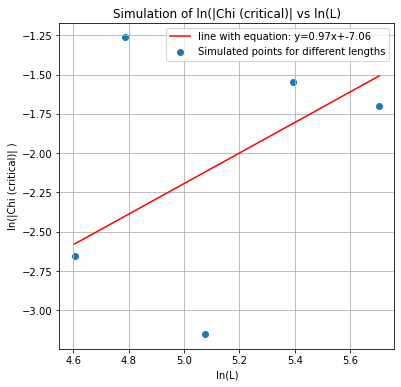

In [283]:
fig = plt.figure(figsize=(6,6))
plt.xlabel("ln(L)")
plt.ylabel("ln(|Chi (critical)| )")
plt.title("Simulation of ln(|Chi (critical)| vs ln(L)")
plt.scatter(np.log(L_listO),np.log(XiclistO),label='Simulated points for different lengths')
plt.plot(np.log(Lg_list),np.log(Lg_list)*fit[0]+fit[1],color='r',label='line with equation: y='+str(round(fit[0], 2))+'x+'+str(round(fit[1],2)))
plt.tick_params(labelsize=10)
plt.legend()
plt.grid()
mio = (fit[0]*nu)
print('mio is',mio)

C0

In [277]:
Jclist2= [listt2[np.argmax(Cvlist2)],listt3[np.argmax(Cvlist3)],listt4[np.argmax(Cvlist4)],listt5[np.argmax(Cvlist5)]]
Cvclist= [Cvlist2[np.argmax(Cvlist2)],Cvlist3[np.argmax(Cvlist3)],Cvlist4[np.argmax(Cvlist4)],Cvlist5[np.argmax(Cvlist5)]]
Jc_list2 = [np.abs(x - Jcrit) for x in Jclist2]
T_list2 = [np.abs(x**-1 - Jcrit**-1) for x in Jclist2]
CvclistO= [Cvlist1[np.argmax(Cvlist1)],Cvlist2[np.argmax(Cvlist2)],Cvlist3[np.argmax(Cvlist3)],Cvlist4[np.argmax(Cvlist4)],Cvlist5[np.argmax(Cvlist5)]]

In [278]:
fit=np.polyfit(np.log(T_list2),(Cvclist),1)

C0 is 122530.36289472034


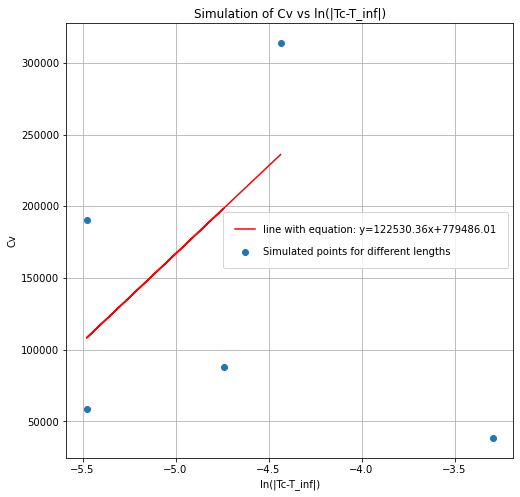

In [279]:
fig = plt.figure(figsize=(8,8))
plt.xlabel("ln(|Tc-T_inf|)")
plt.ylabel("Cv")
plt.title("Simulation of Cv vs ln(|Tc-T_inf|)")
plt.scatter(np.log(T_listO),(CvclistO),label='Simulated points for different lengths')
plt.plot(np.log(T_list2),np.log(T_list2)*fit[0]+fit[1],color='r',label='line with equation: y='+str(round(fit[0], 2))+'x+'+str(round(fit[1],2)))
plt.tick_params(labelsize=10)
plt.legend(borderpad=1.2, labelspacing=1.2)
plt.grid()
c0 = (fit[0])
print('C0 is',c0)